# Option Pricing Using The Explicit Finite Difference Method
Alexandru Giurca April 2020

#### Summary
In this project I will implement the explicit finite difference method to price several different derivatives. As the option price is usually described by differential diffusion or parabolic equations, the finite difference method is adequate, since it is used precisely to find numerical solutions for differential equations. After implementing the model, I will compare it with the results obtained by the analytical solution of each instrument.

## 1. Introduction

In this section I give a brief description of the finite difference method and state the problem that will be addressed. 

### 1.1. The Method Used

As stated by Wilmott, finding closed solutions for pricing many derivatives can be difficult, or even impracticable. As the price of these instruments is often described by partial differential equations, numerical methods are often used to find a solution, such as binomial trees, Monte Carlo simulation or finite differences.

The finite difference method finds the value of a derivative by calculating it in every (feasible) price range of the base instrument, including the passage of time until its maturity. Thus, they are similar to binomial trees. However, instead of discretizing asset prices and the passage of time in a tree structure, it discretizes in a grid.

Finite differences are also very suitable for dealing with problems with few dimensions and non-linear differential equations (the price and time are already two, and Wilmott suggests up to four). For many dimensions, the implementation starts to become complicated and inefficient; Monte Carlo would be better. However, if there is early exercise and non-linearity, the finite difference method turns out to be the most viable solution.

### 1.2. The Problem 

Consider an asset whose price dynamics satisfy the following differential equation:

$$\frac{\mathrm{d} S_t}{S_t}=\mu\cdot \mathrm{d}t + \sigma\cdot \mathrm{d}W_{t}$$

Let's  calculate the fair price of a derivative with a European characteristic whose payoff is described by any function $ V_T = V (T, S_T) $, where $ T $ is the maturity of the derivative. $ S_T $ is the price of the underlying asset in $ T $ and you can trade any amount of it at any time. There is no transaction cost (brokerage, fee, bid-ask spread, etc.) and short positions in the underlying are allowed, with no associated costs.

You are asked to implement the explicit finite difference algorithm and calculate the fair price, Delta and Gamma for each instrument below. The values found must be compared with the result of their analytical expressions. The simulation should be done for the payoffs below. $ K $ is the option Strike.
- $V(T, S_T)=ln(S_T)$
- $V(T, S_T)=(ln(S_T))^2$
- $V(T, S_T)=(S_T-K)^2$
- $V(T, S_T)=\mathbf{1}_{S_T > K}$
- $V(T, S_T)=max(S_T-K, 0)$

##  2. Finite Differences

Below, I will present the necessary elements to implement the finite differences method, which are: the differentiation of the necessary partial derivatives using the Grid; the discretization of the final condition for each derivative; and their respective boundary conditions (at the grid boundaries).

### 2.1. Differentiation Grid

According to Wilmott, the grid used by the finite difference method has time and price steps (or price log) that are generally homogeneous. However, there is no restriction on the form of the Grid, as long as the necessary adjustments are made. 

Consider that we can discretize $t$ as $t= T-k\delta t$ and $S$ as $S = i\delta S$, where $i$ and $k$ are their respective steps in the grid, we can write the value option at each point of the grid as:

$$V^{k}_{i} = ( i \delta S, T-k \delta t )$$

Following lecture notes, applying Taylor's approximation to the price of a generic derivative $V(T, S_T)$, I can write the following parabolic differential equation:

$$\frac{\partial V}{\partial t} + a(S, t) \cdot \frac{\partial V^2}{\partial S^2} + b(S, t) \cdot \frac{\partial V}{\partial S} + c(S, t)\cdot V = 0 $$

$\frac{\partial V}{\partial t}$ is also called theta ($\theta$), $\frac{\partial V}{\partial S}$ delta ($\Delta$) and $\frac{\partial V^2}{\partial S^2}$ gamma ($\Gamma$). As demonstrated by Wilmott, the first derivative with regard to $t$ is given by

$$\frac{\partial V}{\partial t} = \underset{h \, \rightarrow \, 0}{\lim}\, \frac{V(S, t + h) - V(S, t)}{h}$$

Then we can approach $\theta$ by $\frac{\partial V}{\partial t}(S, t) \approx \frac{V_{i}^{k}-V_{i}^{k + 1}}{\delta t}$. Note that $i$ has been fixed. I am also ignoring the approximation errors, as I will ignore them in all other differentiations.

The same reasoning can be used to approximate $\Delta$. However, Wilmott still suggests using centered differences (http://math.stackexchange.com/questions/888259/can-someone-explain-in-general-what-a-central-difference-formula-is-andwhat-it), which is given by $\frac{\partial V}{\partial S}(S, t) \approx \frac{V_{i+1}^{k}-V_{i-1}^{k}}{2\delta S}$. The previous discretization could also be used, but this offers a smaller approximation error. The only problem with this approach is that the values $S +\delta S$ and $S-\delta S$ need to be known and at the borders of the grid it is hard to obtain it. Therefore, in these cases I will use discretization using only one side.

Finally, to find the $\gamma$, Wilmott subtracts the forward delta from the backward delta and divides the result by $\delta S$, arriving at the approximation $\frac{\partial V^2}{\partial S^2}(S, t) \approx \frac{V_{i+1}^{k}-2V_{i}^{k}+V_{i-1}^{k}}{\delta S^2}$. All of these results can be checked by applying Taylor expansion.

### 2.2. Terminal Condition and Payoffs

The option value at maturity is simply the payoff. Thus, there is no need to solve anything for $T$, only for $S$. Using finite difference notation, the desired payoffs are as follows:

- $V_{i}^{0}=ln(i\delta S)$
- $V_{i}^{0}=(ln(i\delta S))^2$
- $V_{i}^{0}=(i\delta S-K)^2$
- $V_{i}^{0}=\mathbf{1}_{i\delta S > K}$
- $V_{i}^{0}=max(i\delta S-K, 0)$

As Wilmott explains, the finite difference method starts backwards. It starts from these values, as if we were calculating the price of a derivative for binomial trees, also backwards.

### 2.3. Boundary Conditions

When we are running the Grid, we will need to define the price of the derivative at its extremes, when $S = 0$ and $S = I\delta S$, where $I$ is the highest point of the Grid. This condition depends on the instrument being priced. For all contracts, we will use the following condition for $S = 0$:

$$V^{k}_{0} = (1 - r \delta t)V^{k-1}_{0}$$

For the upper boundary condition, we will use for most contracts

$$V^{k}_{I} = 2V^{k}_{I-1} - V^{k}_{I-2}$$

This condition is appropriate because, as $S \rightarrow \infty$, the $ \Gamma $ of most contracts tends to zero. However, this is not true for the contract whose payoff is described by $ V_{i}^{0}=(i \delta S-K)^2 $. Differentiating again the [delta](https://github.com/AlexandruGiurca/Dynamic-Hedging-Derivatives/blob/master/Dynamic%20Replicating%20Strategy%20of%20Different%20Derivative%20Payoffs.ipynb) of this contract, we conclude that the gamma will be given by $2\cdot e^{(r + \sigma^2)(T-t)}$. In this case, starting from the discrete equation of $ \Gamma $ and solving for $ V^{k}_{I}$, we have
\begin{equation}
\begin{aligned}
\Gamma &= \frac{V_{I+1}^{k} - 2 V_{I}^{k} + V_{I-1}^{k} }{\delta S^2}\\
2 \cdot e^{(r + \sigma^2)(\delta t)} &= \frac{V_{I+1}^{k} - 2 V_{I}^{k} + V_{I-1}^{k} }{\delta S^2}\\
V_{I}^{k} &= 2 \delta S^2 e^{(r + \sigma^2)(\delta t)} + 2V_{I-1}^{k} - V_{I-2}^{k}\\
V_{I}^{k} &\approx 2 \delta S^2 + 2V_{I-1}^{k} - V_{I-2}^{k}\\
\end{aligned}
\end{equation}



## 3. Model Implementation

In this section I will describe the explicit finite difference method and implement the necessary codes.

### 3.1. Explicit Method

Replacing the differentiations found in the parabolic equation mentioned above and rewriting the other terms with finite difference notation, we obtain

\begin{equation}
\begin{aligned}
\frac{\partial V}{\partial t} + a(S, t) \cdot \frac{\partial V^2}{\partial S^2} + b(S, t) \cdot \frac{\partial V}{\partial S} + c(S, t)\cdot V &= 0 \\
\frac{V_{i}^{k} - V_{i}^{k+1} }{\delta t} + a_{i}^{k} \cdot \frac{V_{i+1}^{k} - 2 V_{i}^{k} + V_{i-1}^{k} }{\delta S^2} + \\b_{i}^{k} \cdot \frac{V_{i+1}^{k} - V_{i-1}^{k} }{2 \delta S} + c_{i}^{k}\cdot V_{i}^{k} &= 0
\end{aligned}
\end{equation}

Rearranging the above equation to isolate $V_{i}^{k + 1}$ and rewrite some terms, we get

$$V_{i}^{k+1} = A_{i}^{k}V_{i-1}^{k} + \left( 1 + B_{i}^{k} \right)V_{i}^{k} + C_{i}^{k}V_{i+1}^{k}$$

where

\begin{equation}
\begin{aligned}
A_{i}^{k} &= \nu_1 a_{i}^{k} - 0.5\nu_2 b_{i}^{k} \\
B_{i}^{k} &= -2\nu_1 a_{i}^{k} - \delta t c_{i}^{k} \\
C_{i}^{k} &= \nu_1 a_{i}^{k} + 0.5\nu_2 b_{i}^{k}
\end{aligned}
\end{equation}

$\nu_1 = \frac{\delta t}{\delta S^2}$ and $\nu_2 = \frac{\delta t} {\delta S}$. The above equation is defined only between $i = 1, \dots, I-1$. The remaining points needed for discretization come from the boundary conditions. Since we know the terminal value at $ V_{i}^{0}$, we can calculate the value of $ V_{i}^{1}$ etc. Since the value of the instrument in $k + 1$ only depends on the values of it in $k$, we call this the **explicit method**.

### 3.2. Other Details

#### a. Stability

For the solution of this method to be stable, it is necessary to satisfy $\delta t \, \leqslant \frac{\delta S^2} {2 \sigma^2 S^2}$ and $\delta S \leqslant \frac{2a}{ |b|}$. I will use the first one explicitly in the implementation, but I will make the following transformation:

$$ \delta t \, \leqslant \frac{\delta S^2} {2 \sigma^2 S^2} = \frac{1}{\sigma^2} \left (\frac{\delta S}{S}\right)^2 = \frac{1}{\sigma^2 I^2}$$

where $I=\delta S \times S$.

#### b. Bilinear interpolation

Due to the discretization of the model, it may be necessary to obtain a value that is between the nodes of the Grid. In these cases, I will adopt a two-dimensional interpolation (Price and time) called bilinear interpolation. It consists of performing a linear interpolation first in one direction and then in the other. Considering a specific quadrant of the Grid, in which there are four option prices, the quadrant is basically divided into four (where the dividing points are the desired values) and the area of each one is used as a weight for the option values. So, we end with the following formula:

$$\frac{\sum_{i=1}^{4} A_i V_i}{\sum_{i=1}^{4} A_i}$$

where $A$ is the area of the rectangles and $V$ the option price at each corner of the main quadrant. Each $A_i$ is opposite the corresponding $V_i$.

### 3.3. Creating the Grid

First, I will define the classes for creating the Grid. As I want to access the values later, I will keep them all in one structure, although this is probably not the most appropriate method with speed in mind.

In [1]:
import matplotlib.pylab as plt
import math
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import time
from scipy.optimize import minimize

import finite_difference
x = finite_difference.Grid(f_vol=0.5,
                           f_value=100.,
                           f_time=1.,
                           i_nas=10,
                           i_nts=10)
print(x)

       0     1     2     3     4     5     6     7     8     9
0    0,0   0,1   0,2   0,3   0,4   0,5   0,6   0,7   0,8   0,9
1    1,0   1,1   1,2   1,3   1,4   1,5   1,6   1,7   1,8   1,9
2    2,0   2,1   2,2   2,3   2,4   2,5   2,6   2,7   2,8   2,9
3    3,0   3,1   3,2   3,3   3,4   3,5   3,6   3,7   3,8   3,9
4    4,0   4,1   4,2   4,3   4,4   4,5   4,6   4,7   4,8   4,9
5    5,0   5,1   5,2   5,3   5,4   5,5   5,6   5,7   5,8   5,9
6    6,0   6,1   6,2   6,3   6,4   6,5   6,6   6,7   6,8   6,9
7    7,0   7,1   7,2   7,3   7,4   7,5   7,6   7,7   7,8   7,9
8    8,0   8,1   8,2   8,3   8,4   8,5   8,6   8,7   8,8   8,9
9    9,0   9,1   9,2   9,3   9,4   9,5   9,6   9,7   9,8   9,9
10  10,0  10,1  10,2  10,3  10,4  10,5  10,6  10,7  10,8  10,9


In [2]:
%timeit x = finite_difference.Grid(f_vol=0.2, f_value=100., f_time=1., i_nas=100)

130 ms ± 29.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


As I mentioned, it is not an efficient structure. It took several seconds to create a 10,000 node structure. However, I believe this will help me further.

### 3.3. Testing the method

Following implementation of the book, there is also another option to find $V_{i}^{k+1}$. Replacing the notation of the pricing formula and assuming that we have the values for $\Delta$, $\Gamma$ and $V_{i}^{k}$, we can isolate $\theta$, keeping

\begin{equation}
\begin{aligned}
\theta + a_{i}^{k} \cdot \Gamma + b_{i}^{k} \cdot \Delta + c_{i}^{k}\cdot V_{i}^{k} &= 0\\
-a_{i}^{k} \cdot \Gamma - b_{i}^{k} \cdot \Delta - c_{i}^{k}\cdot V_{i}^{k} &= \theta
\end{aligned}
\end{equation}

Thus, for an option that does not pay dividends, with an underlying asset following a Geometric Brownian Motion, we have the parameter $c=-r$, $b =rS$ and $a = 0.5 \cdot \sigma^2 S^2$ (risk neutral world). So, I get the follwing theta

$$\theta = r V_{i}^{k} - rS_{i}^{k}\Delta - 0.5\sigma^2 S^2\Gamma$$

Then, the price of the derivative at $k + 1$ can be obtained by:

$$V_{i}^{k+1} = V_{i}^{k} - \delta t \theta$$

To compare the results obtained, the prices and greeks for each option will also be calculated analytically, following the analytical equations shown in [the previous notebook](https://github.com/AlexandruGiurca/Dynamic-Hedging-Derivatives/blob/master/Dynamic%20Replicating%20Strategy%20of%20Different%20Derivative%20Payoffs.ipynb). Below I will print the results obtained for a European Call for comparison with examples from Wilmott.

In [4]:
import finite_difference
d_param = {"f_St": 100.,  # preco do ativo
           "f_sigma": 0.2, # desvio padra do ativo objeto
           "f_time": 1.,  # tempo para vencimento em anos
           "f_r": 0.05,  # taxa de juros anual
           "i_nas": 20,  # passos que o ativo sera discretizado
           "i_nts": 10,  # optional
           "f_K": 100.  # strike da opcao
          }

%time self = finite_difference.EuropeanCall(**d_param)

Wall time: 493 ms


In [5]:
# prints only the part of the matrix shown in the book example, page 1216, table 77.1
df = self.df_opt_prices.copy()
df.columns = ["{:.3f}".format(x) for x in df.columns]
df.tail(15).head(9)

,0.000,0.111,0.222,0.333,0.444,0.556,0.667,0.778,0.889,1.000
60.0,0.0,0.000000,0.000000,0.000000,0.000000,0.001046,0.004769,0.012912,0.027040,0.048408
70.0,0.0,0.000000,0.000000,0.000000,0.010816,0.040306,0.092362,0.168004,0.266547,0.386414
80.0,0.0,0.000000,0.000000,0.084278,0.248619,0.475041,0.746832,1.051237,1.379044,1.723707
90.0,0.0,0.000000,0.512500,1.148000,1.807437,2.461115,3.100759,3.724696,4.333380,4.927851
100.0,0.0,2.500000,4.013889,5.200154,6.223712,7.149693,8.008182,8.816223,9.584443,10.320129
110.0,10.0,10.555556,11.571451,12.561620,13.500820,14.389205,15.235188,16.045095,16.824334,17.576942
120.0,20.0,20.555556,21.108025,21.790273,22.510062,23.243401,23.974649,24.698653,25.412183,26.114374
130.0,30.0,30.555556,31.108025,31.657425,32.248867,32.862026,33.491183,34.127231,34.766578,35.405282
140.0,40.0,40.555556,41.108025,41.657425,42.203772,42.764972,43.335178,43.915298,44.500544,45.090213


The column headings refer to the time, starting at maturity (time zero) up to $t$ (the day the option is being valued). The rows refer to the price of the asset. Note that a difference starts to appear in relation to the book when the asset is worth $110.00 $ or less. Since the method uses the three previous underlying nodes to calculate the value of the posterior node, the $(\, 90.0 \,; 0.111)$ node should not have any value at all. However, in Wilmott's example, he did.

## 4. Pricing Instruments

In this section I will price some instruments and compare with their analytical solutions.

### 4.1. European Call

Starting from the previous implementation, it remains only to implement the analytical gamma of the equation, which is given below

$$\frac{\partial V^2}{\partial S^2} = \frac{\Delta}{\partial S} = \frac{N'(d1)}{S \sigma \sqrt{t}} $$

Below I will compare the analytical results with what I got from the finite difference method.

In [6]:
import finite_difference
d_param = {"f_St": 100.,  # initial state of the asset
           "f_sigma": 0.5, # standard deviation for dynamics
           "f_time": .5,  # time elapsed in the simulation
           "f_r": 0.10,  # interest rate annually
           "i_nas": 20,  # steps for discretization
           "f_K": 100.  # strike price
          }

%time my_option = finite_difference.EuropeanCall(**d_param)

Wall time: 2.6 s


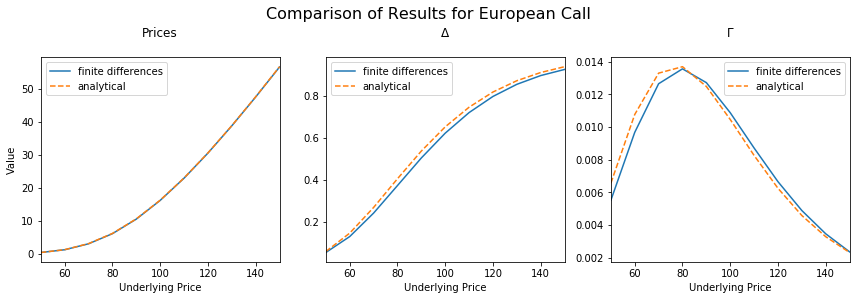

In [7]:
# plotting graphs from the beginning of the period
l_prices = np.arange(50., 151., 1.)
my_option.compare_to_analytical_solutions(l_prices, d_param['f_time'])

### 4.2. Log Contract

Deriving analytical gamma of the equation from the Delta $\Delta = \frac{e^{-r\cdot t}}{S}$ as

\begin{equation}
\begin{aligned}
\frac{\partial V^2}{\partial S^2} &= \frac{\Delta}{\partial S} = -\frac{e^{-r\cdot t}}{S^2}
\end{aligned}
\end{equation}

Below I will compare the analytical results with what I got from the finite difference method. The only difference that needs to be taken into consideration is that in this implementation - when the asset value at the end is $0$ - I set the option value also equal to $0$.

In [9]:
import finite_difference
d_param = {"f_St": 100.,  # initial state of the asset
           "f_sigma": 0.5, # standard deviation for dynamics
           "f_time": .5,  # time elapsed in the simulation
           "f_r": 0.10,  # interest rate annually
           "i_nas": 20,  # steps for discretization
           "f_K": 100.  # strike price
          }

%time my_option = finite_difference.LogContract(**d_param)

Wall time: 2.17 s


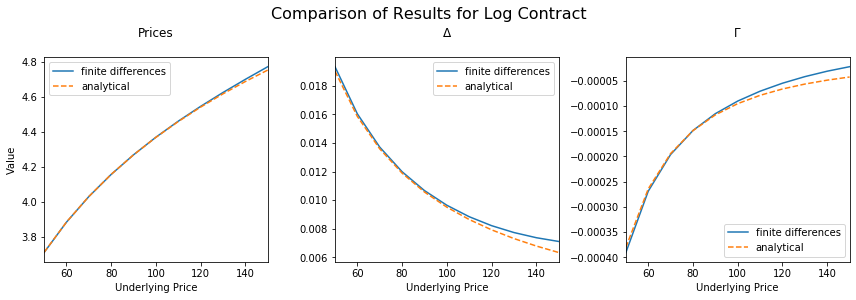

In [10]:
# plotting graphs from the beginning of the period
l_prices = np.arange(50., 151., 1.)
my_option.compare_to_analytical_solutions(l_prices, d_param['f_time'])

### 4.3. Squared Log Contract

Deriving analytical gamma from the equation and applying the quotient rule:

$$\Delta = \frac{2e^{-r\cdot t}}{S}\left[ln(S)+ \left(r - \frac{\sigma^2}{2} \right) \cdot t \right]$$

Thus,

\begin{equation}
\begin{aligned}
\frac{\partial V^2}{\partial S^2} &= \frac{\Delta}{\partial S}= 2e^{-r\cdot t} \frac{\partial}{\partial S} \left [ \frac{ln(S)+ t \left(r - \frac{\sigma^2}{2} \right)}{S} \right ]\\
&= 2e^{-r\cdot t} \frac{S \frac{\partial}{\partial S} \left ( ln(S)+ t \left(r - \frac{\sigma^2}{2} \right) \right) - \left( ln(S)+ t \left(r - \frac{\sigma^2}{2} \right) \right) \frac{\partial}{\partial S} (S)}{S^2}\\
&= 2e^{-r\cdot t} \frac{S \cdot \frac{1}{S} - ln(S)- tr + \frac{t \sigma^2}{2}}{S^2}\\
&= \frac{e^{-r t}}{S^2}\left[2 + \sigma^2 t - 2ln(S) -2rt\right]
\end{aligned}
\end{equation}

In [12]:
import finite_difference
d_param = {"f_St": 100.,  # initial state of the asset
           "f_sigma": 0.5, # standard deviation for dynamics
           "f_time": .5,  # time elapsed in the simulation
           "f_r": 0.10,  # interest rate annually
           "i_nas": 20,  # steps for discretization
           "f_K": 100.  # strike price
          }

%time my_option = finite_difference.SquaredLogContract(**d_param)

Wall time: 2.35 s


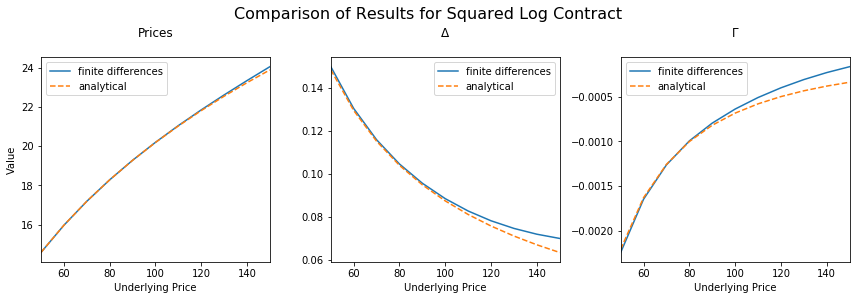

In [13]:
# plotting graphs from the beginning of the period
l_prices = np.arange(50., 151., 1.)
my_option.compare_to_analytical_solutions(l_prices, d_param['f_time'])

### 4.4. Exotic Squared Contract

Deriving analytical gamma of the equation from $\Delta = 2S e^{(r + \sigma^2)} - 2K$:

\begin{equation}
\begin{aligned}
\frac{\partial V^2}{\partial S^2} &= 2 e^{(r + \sigma^2)}
\end{aligned}
\end{equation}


In this case, I also need to **change the boundary conditions**. Below I will compare the analytical results with what I got from the finite difference method.

In [14]:
import finite_difference
d_param = {"f_St": 100.,  # initial state of the asset
           "f_sigma": 0.5, # standard deviation for dynamics
           "f_time": .5,  # time elapsed in the simulation
           "f_r": 0.10,  # interest rate annually
           "i_nas": 20,  # steps for discretization
           "f_K": 100.  # strike price
          }

%time my_option = finite_difference.SquaredExotic(**d_param)

Wall time: 2.16 s


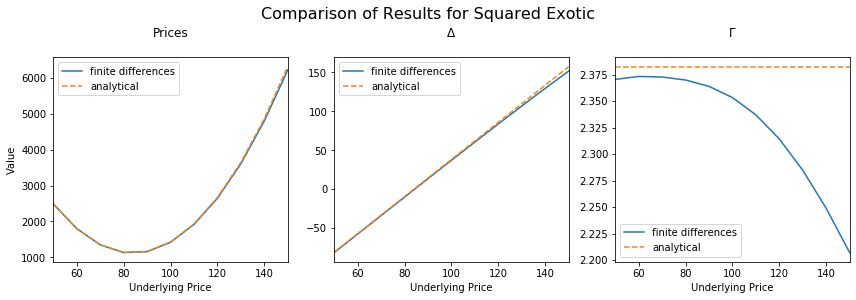

In [15]:
# plotting graphs from the beginning of the period
l_prices = np.arange(50., 151., 1.)
my_option.compare_to_analytical_solutions(l_prices, d_param['f_time'])

### 4.5. Digital Option

Finally, I will compare the result of the explicit method with the analytical result of a digital option. Following the derivation of the analytical gamma from [here](http://www.stat.nus.edu.sg/~stalimtw/MFE5010/PDF/L2digital.pdf)

\begin{equation}
\begin{aligned}
\frac{\partial V^2}{\partial S^2} &= - \frac{e^{-rt} d_1 N(d_2) }{S^2 \sigma^2 t }
\end{aligned}
\end{equation}

In [17]:
import finite_difference
d_param = {"f_St": 100.,  # initial state of the asset
           "f_sigma": 0.5, # standard deviation for dynamics
           "f_time": .5,  # time elapsed in the simulation
           "f_r": 0.10,  # interest rate annually
           "i_nas": 20,  # steps for discretization
           "f_K": 100.  # strike price
          }

%time my_option = finite_difference.DigitalOption(**d_param)

Wall time: 2.54 s


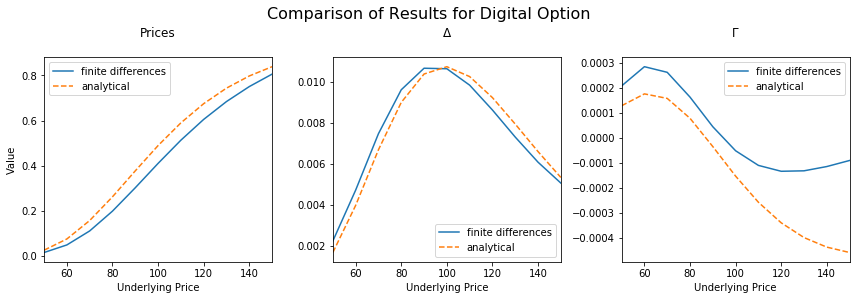

In [18]:
# plotting graphs from the beginning of the period
l_prices = np.arange(50., 151., 1.)
my_option.compare_to_analytical_solutions(l_prices, d_param['f_time'])

The solution did not adhere very well to the analytical solutions. I will try to improve the amount of discretization of the underlying asset to try to improve the results

In [19]:
import finite_difference
d_param = {"f_St": 100.,  # initial state of the asset
           "f_sigma": 0.5, # standard deviation for dynamics
           "f_time": .5,  # time elapsed in the simulation
           "f_r": 0.10,  # interest rate annually
           "i_nas": 100,  # steps for discretization
           "f_K": 100.  # strike price
          }

%time my_option = finite_difference.DigitalOption(**d_param)

Wall time: 5min 59s


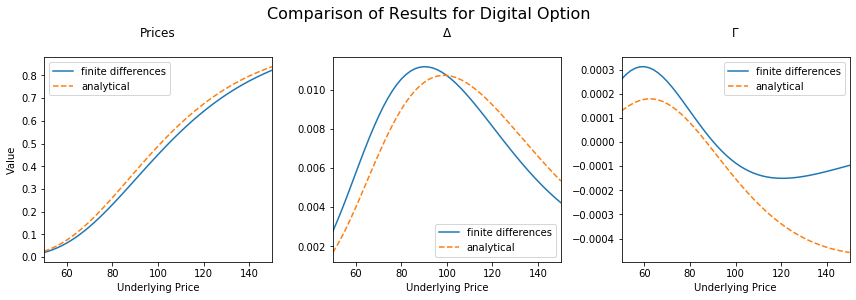

In [20]:
# plotting graphs from the beginning of the period
l_prices = np.arange(50., 151., 1.)
my_option.compare_to_analytical_solutions(l_prices, d_param['f_time'])

Interestingly, the improvement was marginal. The implementation that I did also proved to be inadequate, since when I created a grid with $100$ active steps, it took 6 minutes to perform all the calculations.

## 5. Finite Differences Method Using Uncertain Volatility: Static Hedging

Below, I am going to apply a method described by Wilmott in his Book called **Static Hedging**. The charts above compare the solution using the implemented method and the analytical solution for an European call at the expirity. Now, let's introduce uncertain volatility. It is pretty simple. I just need to compare the current gamma and chose one of the values passed. Let's implement it.

In [25]:
import finite_difference
import numpy as np

d_param = {"f_St": 100.,  # initial state of the asset
           "f_sigma": 0.5, # standard deviation for dynamics
           "f_time": .5,  # time elapsed in the simulation
           "f_r": 0.10,  # interest rate annually
           "i_nas": 20,  # steps for discretization
           "f_K": 100.,  # strike price
           "f_sigmam": 0.25 # the minimum vol to be observed
          }

%time my_option = finite_difference.EuropeanCall(**d_param)

Wall time: 5.26 s


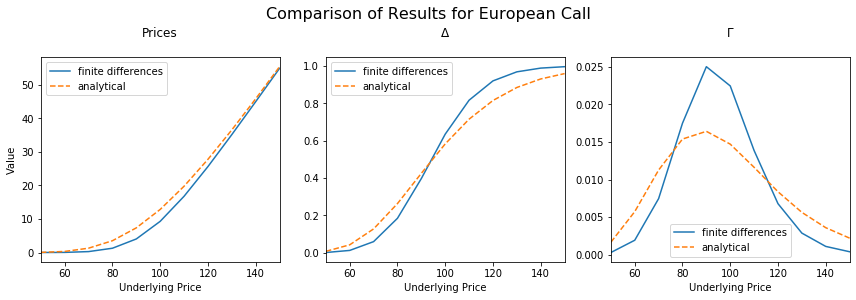

In [26]:
# plotting graphs from the beginning of the period
l_prices = np.arange(50., 151., 1.)
my_option.compare_to_analytical_solutions(l_prices, d_param['f_time'])

A diference is not observable. Let's try the squared payoff.

In [27]:
import finite_difference

d_param = {"f_St": 100.,  # initial state of the asset
           "f_sigma": 1, # standard deviation for dynamics
           "f_time": .5,  # time elapsed in the simulation
           "f_r": 0.10,  # interest rate annually
           "i_nas": 20,  # steps for discretization
           "f_K": 100.,  # strike price
           "f_sigmam": 0.05  # the minimum vol to be observed
          }

%time my_option = finite_difference.SquaredLogContract(**d_param)

Wall time: 19.2 s


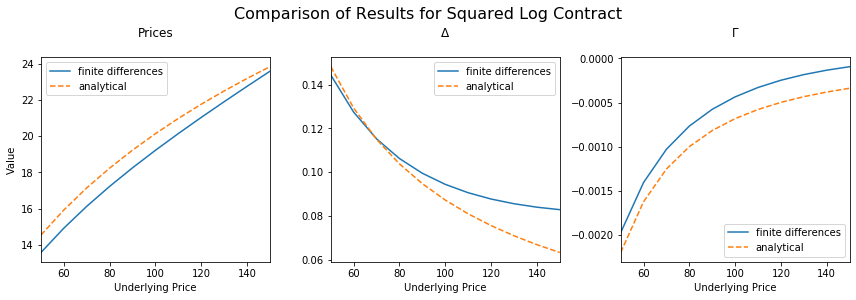

In [28]:
# plotting graphs from the beginning of the period
l_prices = np.arange(50., 151., 1.)
my_option.compare_to_analytical_solutions(l_prices, d_param['f_time'])

To compare, let's plot without using the uncertain volatility:

Wall time: 32.4 s


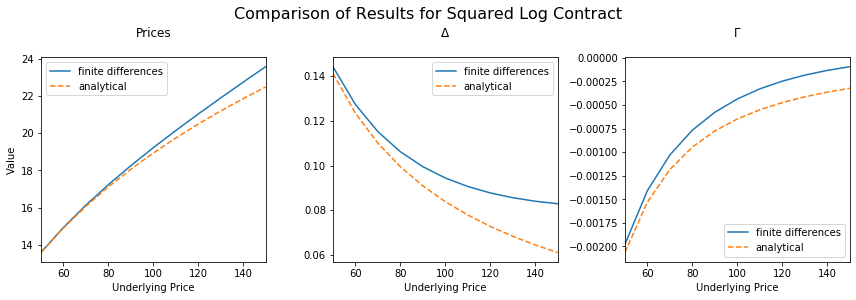

In [30]:
import finite_difference
d_param = {"f_St": 100.,  # initial state of the asset
           "f_sigma": 1, # standard deviation for dynamics
           "f_time": .5,  # time elapsed in the simulation
           "f_r": 0.10,  # interest rate annually
           "i_nas": 20,  # steps for discretization
           "f_K": 100.  # strike price
          }

%time my_option = finite_difference.SquaredLogContract(**d_param)
l_prices = np.arange(50., 151., 1.)
my_option.compare_to_analytical_solutions(l_prices, d_param['f_time'])

It can be seen that the option has a much lower price if UVM is used instead of BS. Now, let's use it to price a **European Call Butterfly**.

Wall time: 233 ms


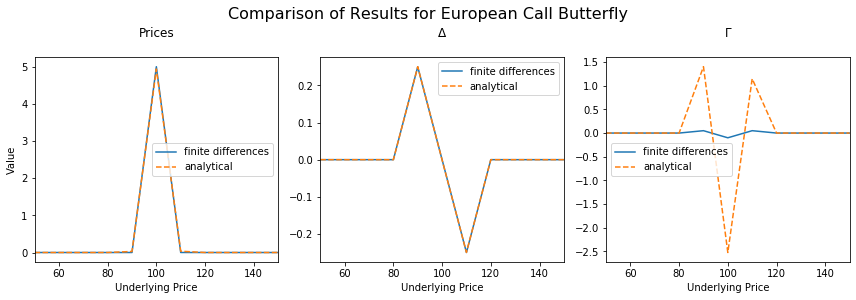

In [33]:
import finite_difference
d_param = {"f_St": 100.,  # initial state of the asset
           "f_sigma": .5, # the maximum volatility
           "f_time": 10e-6,   # time elapsed in the simulation
           "f_r": 0.10,  # interest rate annually
           "i_nas": 20,  # steps for discretization
           "l_K": [90., 100., 110.],  # strike price
           "l_Q": [.5, -1., .5]  # qty normalized of each leg
          }

%time my_option = finite_difference.EuropeanCallButterfly(**d_param)
l_prices = np.arange(50., 151., 1.)
my_option.compare_to_analytical_solutions(l_prices, d_param['f_time'])

 With a long time to expiration:

Wall time: 18 s


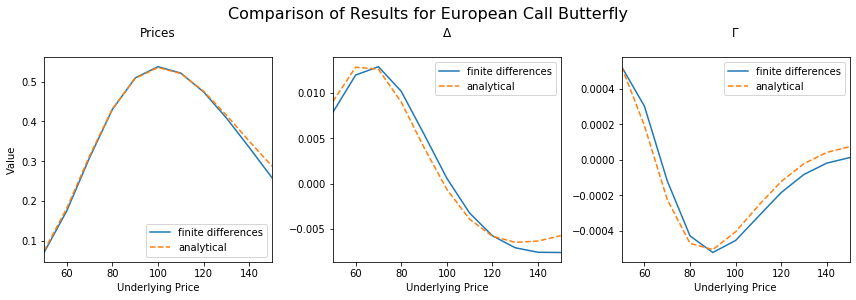

In [35]:
import finite_difference
d_param = {"f_St": 100.,  # initial state of the asset
           "f_sigma": .5, # the maximum volatility
           "f_time": 0.5,  # time elapsed in the simulation
           "f_r": 0.10,  # interest rate annually
           "i_nas": 20,  # steps for discretization
           "l_K": [90., 100., 110.],  # strike price
           "l_Q": [.5, -1., .5]  # qty normalized of each leg
          }

%time my_option = finite_difference.EuropeanCallButterfly(**d_param)
l_prices = np.arange(50., 151., 1.)
my_option.compare_to_analytical_solutions(l_prices, d_param['f_time'])

Using UVM now:

Wall time: 5.55 s


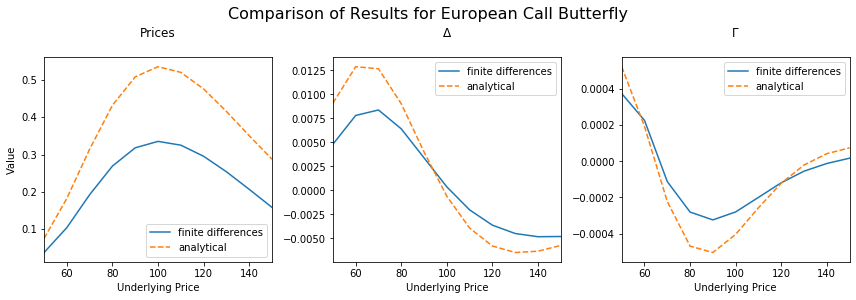

In [37]:
import finite_difference
d_param = {"f_St": 100.,  # initial state of the asset
           "f_sigma": .55, # the maximum volatility
           "f_time": 0.5,  # time elapsed in the simulation
           "f_r": 0.10,  # interest rate annually
           "i_nas": 20,  # steps for discretization
           "l_K": [90., 100., 110.], # strike price
           "l_Q": [.5, -1., .5],  # qty normalized of each leg
           "f_sigmam": .45, # the minimum volatility
          }

%time my_option = finite_difference.EuropeanCallButterfly(**d_param)
l_prices = np.arange(50., 151., 1.)
my_option.compare_to_analytical_solutions(l_prices, d_param['f_time'])

Wall time: 5.68 s


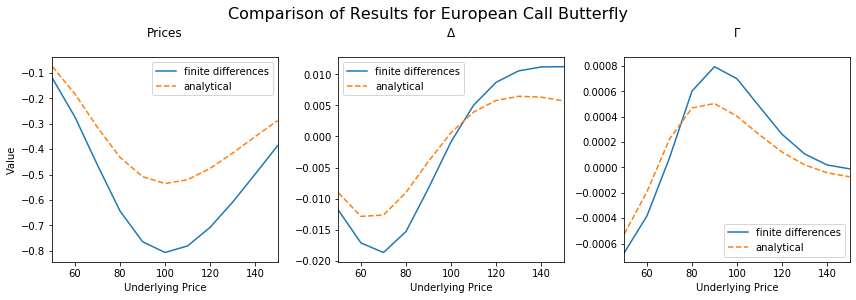

In [38]:
import finite_difference
d_param = {"f_St": 100.,   # initial state of the asset
           "f_sigma": .55, # the maximum volatility
           "f_time": 0.5,  # time elapsed in the simulation
           "f_r": 0.10,  # interest rate annually
           "i_nas": 20,  # steps for discretization
           "l_K": [90., 100., 110.],  # strike price
           "l_Q": [-.5, 1., -.5], # qty normalized of each leg
           "f_sigmam": .45, # the minimum volatility
          }

%time my_option = finite_difference.EuropeanCallButterfly(**d_param)
l_prices = np.arange(50., 151., 1.)
my_option.compare_to_analytical_solutions(l_prices, d_param['f_time'])

Let's see what combination here would yield the best bid/ask price to the strategy.

In [39]:
from scipy.optimize import basinhopping
from scipy.optimize import leastsq

In [42]:
def value_to_minimize(x):
    d_param = {"f_St": 100.,  # initial state of the asset
               "f_sigma": .55, # the maximum volatility
               "f_time": 0.5, # time elapsed in the simulation
               "f_r": 0.10,  # interest rate annually
               "i_nas": 20,  # steps for discretization
               "l_K": [90., 100., 110.],  # strike price
               "l_Q": [-x[0], 1., -x[1]],  # qty normalized of each leg
               "f_sigmam": .45, # the minimum volatility
              }

    my_option = finite_difference.EuropeanCallButterfly(**d_param)    
    f_price_anlt = my_option.get_information(100., 0.5, "price_anlt")
    f_price = my_option.get_information(100., 0.5, "price")
    return (f_price_anlt - f_price)**2

def print_fun(x, f, accepted):
    print("at minimum %.4f accepted %d" % (f, int(accepted)))

In [43]:
value_to_minimize([0.5, 0.5])

0.07351709966588235

In [46]:
import time
f_start = time.time()
l_aux = []
for f_x1 in [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1., 1.1 ]:
    for f_x2 in [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1., 1.1 ]:
        f_aux = value_to_minimize([f_x1, f_x2])
        l_aux.append({'x1': f_x1, 'x1': f_x2, 'err': f_aux})
print("took {:0.2f} seconds to run".format(time.time() - f_start))

took 607.07 seconds to run


Let's plot the result to check if there is a global minimum here.

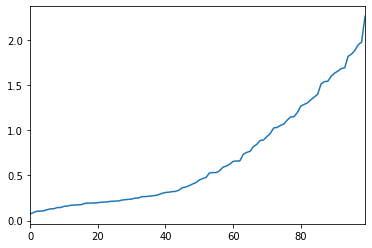

In [47]:
import pandas as pd
df = pd.DataFrame(l_aux)
df.sort_values(by='err').reset_index(drop=True)['err'].plot()

## 6. Conclusion

In this work, the explicit finite difference method was compared to the pricing of instruments with an analytical solution. In general, the method was able to approximate the price of the options well and proved to be quite flexible, requiring few adjustments to price each instrument. Although not tested here, the inclusion of non-linearities in contracts would probably not require many adjustments, such as the use of uncertain parameters, or even early exercise.

## 7.  Last Considerations

The decision to use classes instead of an array made implementation difficult. The application of the method creating an object for each Grid node was also very slow. However, it was interesting to note that the simple increase in grid discretization did not improve adherence to the values calculated by the analytical solutions as much. Perhaps changing the grid format would show better results.

## 8. References

 - P. Wilmott. Paul Wilmott on Quantitative Finance 3 Volume Set (2nd Edition). Wiley, 2006. [link](https://books.google.nl/books?id=hOf-ugEACAAJ&dq=paul+wilmott+on+quantitative+finance+3+volume+set&hl=en&sa=X&ved=0ahUKEwiIuNnj-KPpAhWDzaQKHYa2B2QQ6AEIQDAD)